In [6]:
# !pip install ema_workbench\[recommended\]

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Connect model with the workbench

In [8]:
from ema_workbench import (
    Model,
    RealParameter,
    ScalarOutcome,
    Constant,
    ema_logging,
    MultiprocessingEvaluator,
    CategoricalParameter,
    Scenario,
    save_results,
    load_results,
)

from lake_model_dps import lake_problem

# allways enable loging when working with the workbench
ema_logging.log_to_stderr(ema_logging.INFO)

# instantiate the model
lake_model = Model("lakeproblem", function=lake_problem)

# specify uncertainties
lake_model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
lake_model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]
# specify outcomes
lake_model.outcomes = [
    ScalarOutcome("max_P", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]

# let's optimze the policies for a reference scenario

In [9]:
reference = Scenario("reference", b=0.41, q=2, mean=0.045)

In [13]:
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress

convergence_metrics = [
    ArchiveLogger(
        "./data",
        [l.name for l in lake_model.levers],
        [o.name for o in lake_model.outcomes],
        base_filename="lake_model_dps_archive.tar.gz",
    ),
    EpsilonProgress(),
]

with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(
        searchover="levers",
        nfe=100000,
        epsilons=[0.05] * len(lake_model.outcomes),
        reference=reference,
        convergence=convergence_metrics,
    )

[MainProcess/INFO] pool started with 10 workers
100025it [09:43, 171.34it/s]                                                   
[MainProcess/INFO] optimization completed, found 11 solutions
[MainProcess/INFO] terminating pool


In [14]:
results.to_csv("./data/optimization_results.csv")

## analyze convergence

In [15]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem

In [16]:
problem = to_problem(lake_model, searchover="levers")

hv = HypervolumeMetric(results, problem)
gd = GenerationalDistanceMetric(results, problem, d=1)
ei = EpsilonIndicatorMetric(results, problem)
ig = InvertedGenerationalDistanceMetric(results, problem, d=1)
sm = SpacingMetric(problem)

In [17]:
archives = ArchiveLogger.load_archives("./data/lake_model_dps_archive.tar.gz")

In [18]:
metrics = []
for key in sorted(archives.keys()):
    archive = archives[key]
    scores = {
        "generational_distance": gd.calculate(archive),
        "hypervolume": hv.calculate(archive),
        "epsilon_indicator": ei.calculate(archive),
        "inverted_gd": ig.calculate(archive),
        "spacing": sm.calculate(archive),
        "nfe": int(key),
    }
    metrics.append(scores)
metrics = pd.DataFrame.from_dict(metrics)

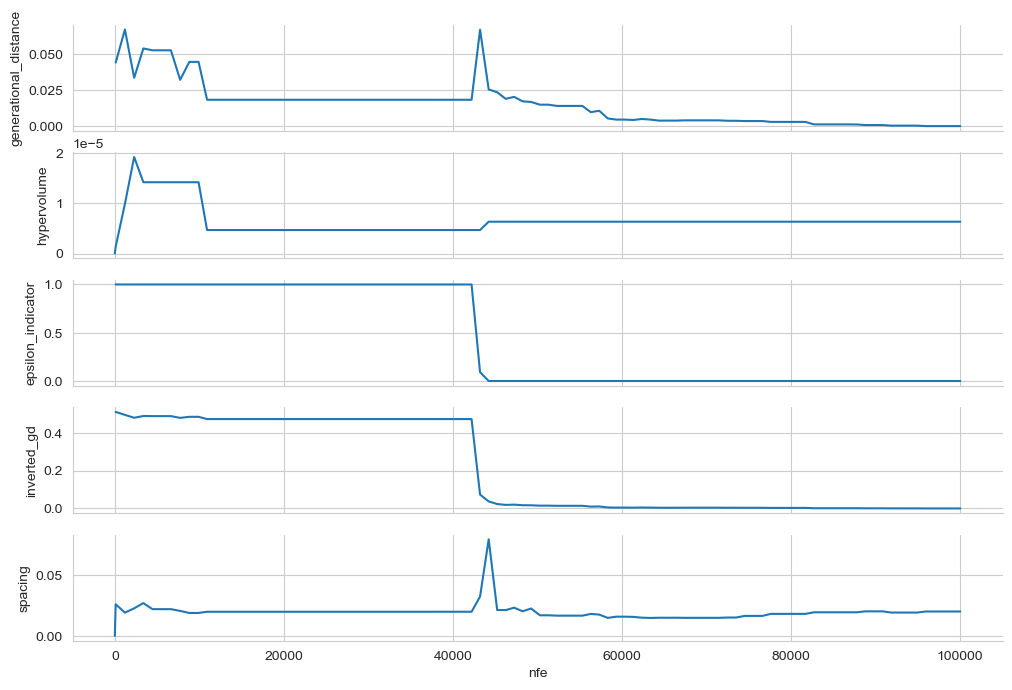

In [19]:
fig, axes = plt.subplots(nrows=5, sharex=True)

for i, entry in enumerate(
    [
        "generational_distance",
        "hypervolume",
        "epsilon_indicator",
        "inverted_gd",
        "spacing",
    ]
):
    ax = axes[i]
    ax.plot(metrics.loc[:, "nfe"], metrics.loc[:, entry])
    ax.set_ylabel(entry)
axes[-1].set_xlabel("nfe")
sns.despine()
plt.show()

# view results

In [20]:
from ema_workbench.analysis import parcoords

results = pd.read_csv("./data/optimization_results.csv", index_col=0)

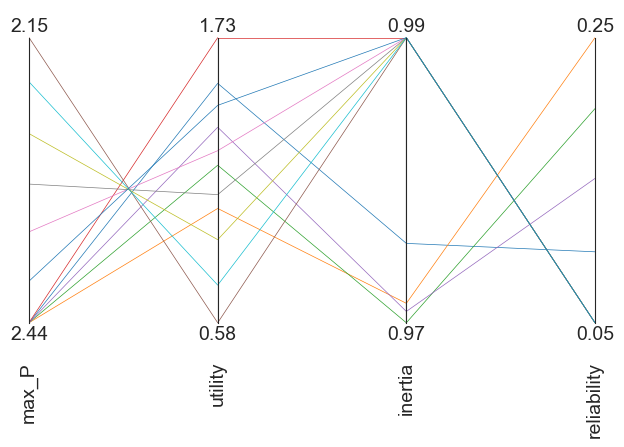

In [21]:
limits = parcoords.get_limits(results.iloc[:, 5::])
parplot = parcoords.ParallelAxes(limits)
parplot.plot(results.iloc[:, 5::], lw=0.5)
parplot.invert_axis("max_P")

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.show()

# reevaluate selected polices under deep uncertainty

In [54]:
maxima_results = results.iloc[:, 6::].idxmax().unique()
minima_results = results.iloc[:, 6::].idxmin().unique()

In [55]:
combined_indices = np.concatenate([minima_results, maxima_results])

In [56]:
unique_indices = np.unique(combined_indices)

In [57]:
results.iloc[unique_indices]

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
7,0.288820,-0.219019,0.376433,1.300196,0.875974,0.191112,0.452666,0.9900,1.0000
9,0.256992,-0.099751,0.112100,1.802057,0.705474,0.514774,0.600043,0.8431,0.9013
33,0.167515,0.809628,0.071429,1.629087,0.830117,2.421800,1.707543,0.9858,0.0734
37,0.252113,0.925750,0.454501,1.948262,0.919605,0.148101,0.377830,0.9900,1.0000


In [58]:
policies = []
for i, row in results.iloc[unique_indices, 0:5].iterrows():
    policy = Policy(f"{i}", **row.to_dict())
    policies.append(policy)
    print(policy)

Policy({'c1': 0.2888197954456862, 'c2': -0.2190194678698486, 'r1': 0.3764326322568374, 'r2': 1.3001959764740785, 'w1': 0.8759742948052336})
Policy({'c1': 0.2569921234197708, 'c2': -0.0997510677094034, 'r1': 0.1121004201870498, 'r2': 1.80205737755322, 'w1': 0.705474479685676})
Policy({'c1': 0.1675146491773321, 'c2': 0.8096284131385665, 'r1': 0.0714291258956338, 'r2': 1.6290868456804486, 'w1': 0.8301165501135789})
Policy({'c1': 0.2521130028248076, 'c2': 0.925750373418689, 'r1': 0.454501075193352, 'r2': 1.948262369890068, 'w1': 0.9196054159329452})


In [120]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(1000, policies=policies)
save_results((experiments, outcomes), "./data/reevaluted.tar.gz")

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
100%|█████████████████████████████████████| 3000/3000 [00:15<00:00, 192.74it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
experiments, outcomes = load_results("./data/reevaluted.tar.gz")

[MainProcess/INFO] results loaded successfully from /Users/jhkwakkel/Documents/GitHub/dmdu_tutorial/src/data/reevaluted.tar.gz


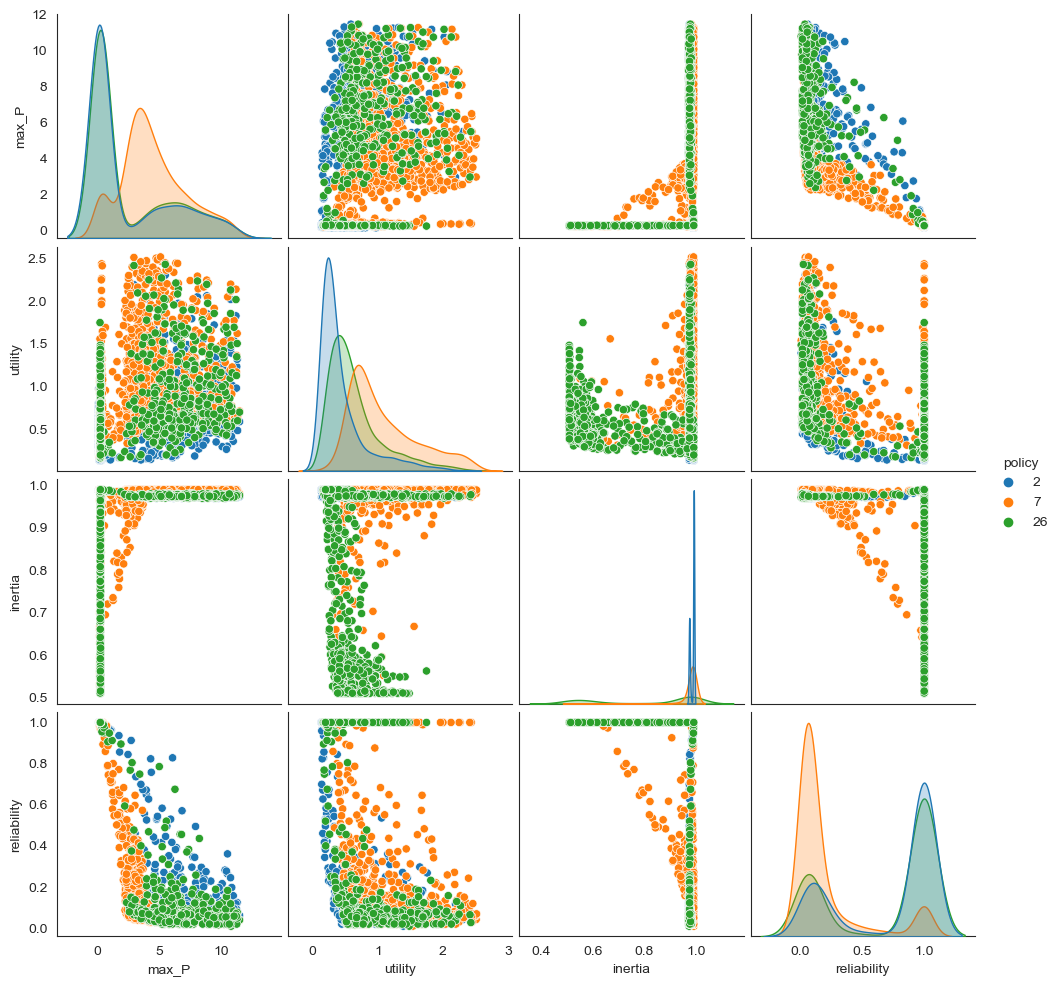

In [20]:
data = pd.DataFrame.from_dict(outcomes)
data["policy"] = experiments.policy
sns.pairplot(data, hue="policy")
plt.show()

# calculate robustness

In [21]:
data = pd.DataFrame.from_dict(outcomes)
data["scenario"] = experiments.scenario.astype(int)

In [22]:
def calculate_best_performance(df):
    data = {}

    for outcome in lake_model.outcomes:
        if outcome.kind == ScalarOutcome.MAXIMIZE:
            data[outcome.name] = df[outcome.name].max()
        else:
            data[outcome.name] = df[outcome.name].min()

    return pd.Series(data)

In [23]:
best_performance = data.groupby("scenario").apply(calculate_best_performance)

In [24]:
def calculate_regret(df):
    df = df.set_index("scenario")
    df.drop("policy", axis=1, inplace=True)
    return best_performance - df

In [25]:
data["policy"] = experiments.policy

In [26]:
regret = data.groupby("policy").apply(calculate_regret)

In [27]:
max_regret = regret.groupby(level=0).apply(calculate_best_performance)
max_regret

,max_P,utility,inertia,reliability
policy,,,,
2,-0.002841,2.188907,0.0200,0.0009
7,-9.627019,0.497873,0.4619,0.9561
26,-7.916725,2.151758,0.4800,0.9174


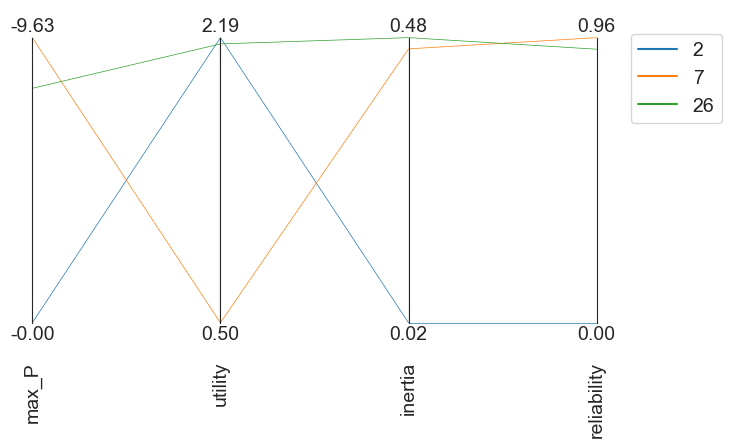

In [36]:
colors = sns.color_palette()

limits = parcoords.get_limits(max_regret)
parplot = parcoords.ParallelAxes(limits)


for (i, row), c in zip(max_regret.iterrows(), colors):
    parplot.plot(row, lw=0.5, label=f"{i}", color=c)
parplot.invert_axis("max_P")
parplot.legend()

fig = plt.gcf()
fig.set_size_inches(6, 4)

plt.show()